# End-To-End Neural Network in Pytorch (GPU)
- Now, we want to make it flexible such that it can use CPU or GPU (if it's available)
- In order for us to do so, we simply have to think of three things:
    1. Loading Data and Labels to GPU during training
    2. Loading Data and Lables to GPU during evaluation
    3. Loading Models into GPU
    

## Load Typical Packages

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt

%matplotlib inline

In [14]:
# For colab users
# from google.colab import drive

## Gather your dataset
- In this case, we want MNIST dataset.
- Fortunately, this is already built-in from torchvision package

In [15]:
from torchvision import datasets, transforms

# Check if CUDA at slot 0 is available or not. Otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Define a transform to augment the data. 
# Transform #1 = we want to convert everything into tensor format so that we can streamline pytorch packages
# Transform #2 = Normalize. This is used for data cleaning so that you can help the model perform better.
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

#Load your MNIST Dataset
# If you check the documentation of MNIST method, 
#              argument #1 = directory to save the fetched dataset
#              argument #2 (download)  = do we download if you don't have on the said directory?
#              argument #3 (train)     = what type of dataset?
#              argument #4 (transform) = which transformation do you like to do? 
train_set = datasets.MNIST('drive/My Drive/mnist', download=True, train=True, transform=transform)
test_set = datasets.MNIST('drive/My Drive/mnist', download=True, train=False, transform=transform)

We then try to check what does it look it

In [16]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: drive/My Drive/mnist
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None

From above, we see that the `Dataset` object is like a folder structure. It provides you a mechanism to see its properties. 

*Recall*: In our previous lesson, we showed that training models in pytorch was done using the built-in `for` loop of Python. Our dataset that time was just using list of random numbers. 

But now that we are using real-world dataset via `Dataset` object. So how do we use it for model training?

We can use `DataLoader` utility to convert the dataset object into an `iterable` object which you can use within `for` loop later on.


In [17]:
# This is a function for you to change it from the dataset structure above into something iterable for the looping statement later on.
trainDataLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

Let's try to check what does one iteration look like.

In [18]:
trainIter = iter(trainDataLoader) # Convert it into python iterable built-in object

images, labels = trainIter.next() #Get the next element

print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


As you can see, torch dimensional format is as follows:  
dim0 = batch size  (i.e. number of images in one batch)  
dim1 = no. of channels  (i.e. number of color channel if you may, e.g. R,G,B)  
dim2 = width  (i.e. how wide the photo in pixel)  
dim3 = height (i.e. how tall the photo in pixel)   

Since the no. of channel is only one, we see that this is 'black-and-white' photo. It is not colored. Technically, this is called a grayscale image.

Note: If you are coming from tensorflow, they have different arrangement of dimension esp no. of channel

## Visualize the dataset
This is how our dataset looks like. Don't forget than a grayscale image is 2D array.

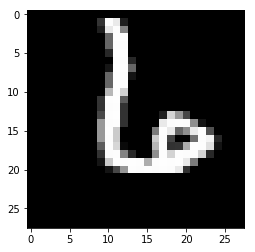

In [19]:
plt.gray()
plt.imshow(images[0].squeeze()) #Note: We get the image 0 from the batch. Thus, it becomes 3 dim. We would 'squeeze' so that it becomes 2 dim.

## NN Module

- this is where we define our Neural Network Architecture

In [20]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        """
            In the constructor we instantiate three nn.Linear modules and assign them as
            member variables.
            Note: we just define components. we have not yet connected them. 
            If you think of it like a graph, we are only declaring nodes, we have not declared edges

            Input:
            D_in: a scalar value that defines the no. of neurons on layer 0 (a.k.a. input layer)
            H1: number of neurons in layer 1
            H2: number of neurons in layer 2
            D_out: number of neurons in layer 3
        """
        super(MLP, self).__init__() #Call the parent class

        self.linear1 = nn.Linear(D_in,H1) # Linear => Linear Transformation. In equation, this is the same as Wx + b.
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(H1,H2)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(H2,D_out)
        self.softmax = nn.LogSoftmax(dim=1) # Softmax is simply sigmoid for multiple classes. That is, if we only have two classes, softmax == sigmoid.
        #Note: We need softmax/sigmoid at the end if it's a classification task. If not, we skip this step.

    def forward(self, x0):
        """
          This is where you define your forward propagation.
          In other words, this is where we combine and connect all the components we defined above.

          Input:
          x0 = the actual image in batch

        """
        # Method View = reshape the tensor into a different dimension.
        # x0.shape[0] = we get the first dim of the image shape. Recall: This would be batch_size
        # -1 = The -1 as the second argument means compute the remaining and that would be my second dimension.
        # Thus, the whole line below means, I want to reshape this batch of images by doing the ff:
        # The first dim of this new 'view' would be based on the first dim of this image. In this case, I would get 64
        # The second dim of this new 'view' would be computed based on the remaining pixels left. Thus, it would be 28*28=784.
        # Thus, The new view would be (64,784)
        x0 = x0.view(x0.shape[0],-1)
        x1 = self.relu1(self.linear1(x0))
        x2 = self.relu2(self.linear2(x1))
        x3 = self.softmax(self.linear3(x2)) 

        return x3

## Model Configurations

In [21]:
seed = 24 #Fave Number. Kobe == 24
torch.manual_seed(seed) # This is set in order to have reproducible and comparable results


D_in = 784 # Number of input neuron in layer 0 (input layer)
H1 = 150   # Number of neuron in layer 1
H2 = 48    # number of neuron in layer 2
D_out = 10 # number of neuron in layer 3 (output layer)

model = MLP(D_in,H1,H2,D_out).to(device) #Note: We transferred it to GPU

epochs = 10 # Number of times it would repeat the whole training process

In [22]:
# Define the cost function
# criterion = torch.nn.MSELoss(reduction='sum')
criterion = nn.NLLLoss() #This is good for classification task

# Define how we would update the weights
optimizer = torch.optim.SGD(model.parameters(),lr=0.0001,momentum=0.9)

## Model Training and Evaluation Framework v4
- At this point we are able to think of reusability and abstractions in mind
- We are able to add plot using Visdom

In [24]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from visdom import Visdom

#We transferred both the model and data to GPU on trainer and evaluator
trainer = create_supervised_trainer(model,optimizer,criterion,device)
evaluator = create_supervised_evaluator(model,metrics={'accuracy':Accuracy(),
                                                      'loss':Loss(criterion)},device=device)
vis = Visdom()

def create_plot_window(vis, xlabel, ylabel, title):
    return vis.line(X=np.array([1]), Y=np.array([np.nan]), opts=dict(xlabel=xlabel, ylabel=ylabel, title=title))

#Initialize all the plot windows we wanted
train_loss_window = create_plot_window(vis,'#Iterations','Loss','Training Avg Loss')
val_loss_window = create_plot_window(vis,'#Iterations','Loss','Val Avg Loss')
train_acc_window = create_plot_window(vis,'#Iterations','Accuracy','Training Avg Accuracy')
val_acc_window = create_plot_window(vis,'#Iterations','Accuracy','Val Avg Accuracy')


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(trainDataLoader)
    avg_accuracy = evaluator.state.metrics['accuracy']
    avg_loss = evaluator.state.metrics['loss']
    epoch = engine.state.epoch
    print("Epoch: {} train Loss: {:.4f} Acc: {:.4f}".format(epoch, avg_loss, avg_accuracy*100))
    
    # Update your plots
    vis.line(X=np.array([epoch]),Y=np.array([avg_loss]),win=train_loss_window,update='append')
    vis.line(X=np.array([epoch]),Y=np.array([avg_accuracy]),win=train_acc_window,update='append')
    
    pass

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(testDataLoader)
    avg_accuracy = evaluator.state.metrics['accuracy']
    avg_loss = evaluator.state.metrics['loss']
    epoch = engine.state.epoch

    print("Epoch: {} Val Loss: {:.4f} Acc: {:.4f}".format(epoch, avg_loss, avg_accuracy*100))
    
    # Update your plots
    vis.line(X=np.array([epoch]),Y=np.array([avg_loss]),win=val_loss_window,update='append')
    vis.line(X=np.array([epoch]),Y=np.array([avg_accuracy]),win=val_acc_window,update='append')


trainer.run(trainDataLoader, max_epochs=epochs)

Epoch: 1 train Loss: 2.1273 Acc: 52.0100
Epoch: 1 Val Loss: 2.1230 Acc: 52.6500
Epoch: 2 train Loss: 1.7639 Acc: 60.5900
Epoch: 2 Val Loss: 1.7521 Acc: 61.3200
Epoch: 3 train Loss: 1.2690 Acc: 71.6350
Epoch: 3 Val Loss: 1.2523 Acc: 72.4600
Epoch: 4 train Loss: 0.9287 Acc: 77.7217
Epoch: 4 Val Loss: 0.9103 Acc: 78.3800
Epoch: 5 train Loss: 0.7468 Acc: 80.3583
Epoch: 5 Val Loss: 0.7283 Acc: 81.0100
Epoch: 6 train Loss: 0.6412 Acc: 82.4767
Epoch: 6 Val Loss: 0.6231 Acc: 83.2500
Epoch: 7 train Loss: 0.5722 Acc: 84.2417
Epoch: 7 Val Loss: 0.5532 Acc: 84.7800
Epoch: 8 train Loss: 0.5241 Acc: 85.4383
Epoch: 8 Val Loss: 0.5055 Acc: 86.1000
Epoch: 9 train Loss: 0.4869 Acc: 86.4783
Epoch: 9 Val Loss: 0.4686 Acc: 87.1100
Epoch: 10 train Loss: 0.4586 Acc: 87.2283
Epoch: 10 Val Loss: 0.4405 Acc: 87.8700
